In [1]:
from Data import get_data_loaders, visualize_one_batch

data_loaders = get_data_loaders(batch_size=10, num_workers=2)
data_loaders.keys()

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


dict_keys(['train', 'valid', 'test'])

Reusing cached mean and std


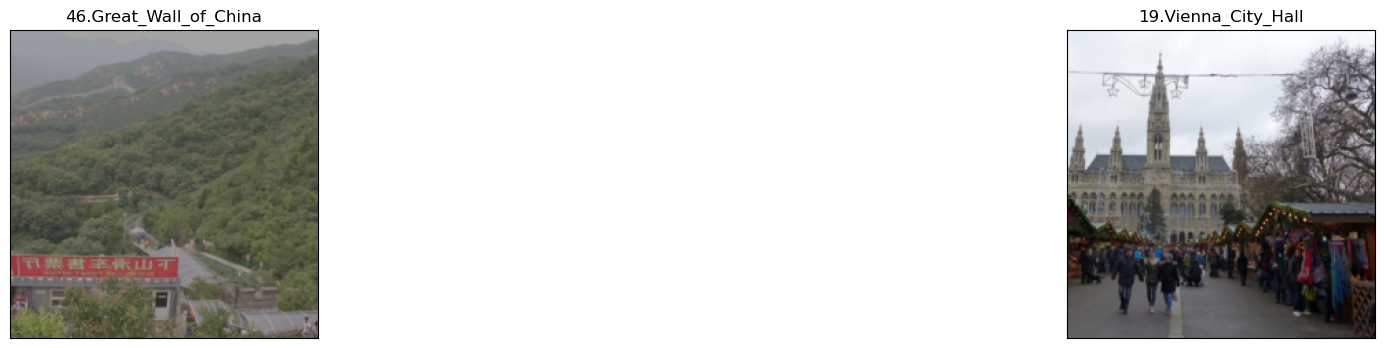

In [2]:
visualize_one_batch(data_loaders, max_n=10)

In [3]:
from LandMarkModel import LandmarkCnnModel

model = LandmarkCnnModel(num_classes=23, dropout=0.3)

dataiter = iter(data_loaders["train"])
images, labels = next(dataiter)

print("Shape of input images:", images.shape)  # Add this line

out = model(images)
out.shape

Shape of input images: torch.Size([2, 3, 224, 224])


torch.Size([2, 23])

In [4]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam) - was 32
valid_size = 0.2       # fraction of the training data to reserve for validation - was 0.2
num_epochs = 2        # number of epochs for training - was 50
num_classes = 50       # number of classes. Do not change this unless the classes in the dataset image folder are changed
dropout = 0.4          # dropout for our model - was 0.4
learning_rate = 0.004  # Learning rate for SGD (or Adam) - was 0.001
opt = 'adam'            # optimizer. 'sgd' or 'adam' - was sgd
weight_decay = 0.0 

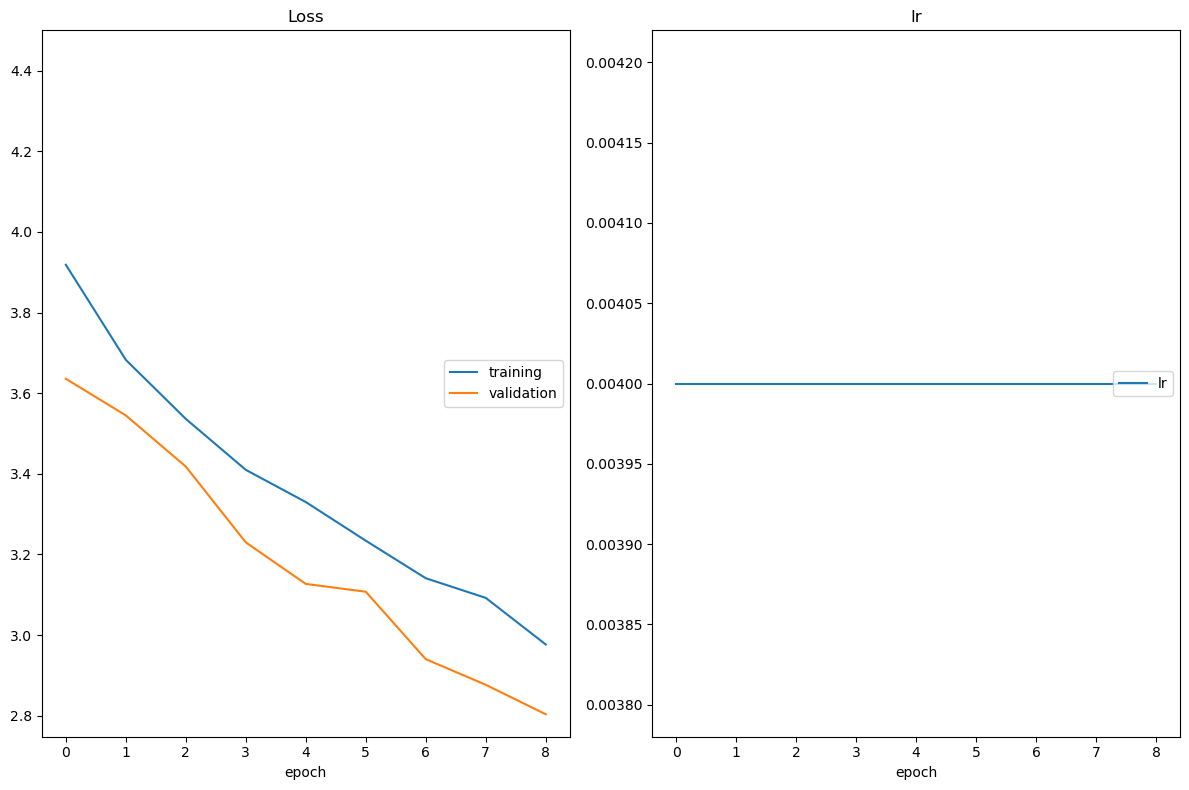

Training:  33%|███████████                      | 21/63 [00:10<00:20,  2.09it/s]

In [ ]:
from Training import optimize
from LandMarkModel import LandmarkCnnModel
from Optimization import get_optimizer, get_loss

# get the data loaders using batch_size and valid_size defined in the previous
# cell
data_loaders = get_data_loaders(batch_size=batch_size,
                                valid_size=valid_size)

# instance model with num_classes and drouput defined in the previous
# cell
model = LandmarkCnnModel(num_classes=num_classes,
               dropout=dropout)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model,
                          learning_rate=learning_rate,
                          optimizer=opt,
                          weight_decay=weight_decay)

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

In [11]:
# load the model that got the best validation accuracy
from Training import one_epoch_test
from LandMarkModel import LandmarkCnnModel
import torch

model = LandmarkCnnModel(num_classes=num_classes, dropout=dropout)

# load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:08<00:00,  2.40it/s]

Test Loss: 2.771861


Test Accuracy: 29% (373/1250)


2.7718612432479857